## ECON 2355 Implementation Exercise 4: Model Optimization and Hyperparameter Tuning

This exercise introduces fundamentals of model optimization. You will add common model features such as Batch Normalization, Temperature, and Data Augmentations to help a simple model learn quickly.

Then, you will use the popular Weights and Biases framework to search for optimal hyperparameter values. Together, these inovations should provide a superior model when compared to the default introduced early in the exercise.

### Notes on the class's implementation exercises in general:

 - These exercises are still being finalized! If you encounter problems please don't hesitate to reach out: tom_bryan@fas.harvard.edu

 - You are welcome to download these notebooks and complete them on your local machine, or work on them in colab. If you are hoping to run things on your local machine you will likely want to set up an [Anaconda](https://www.anaconda.com/products/distribution) python environment and run notebooks from either [VS Code](https://code.visualstudio.com/download) or [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html). For your future Deep Learning-oriented endevours, knowing how to set up an environment to run the frameworks and libraries discussed here will likely be important, so it might not be a bad idea to try setting things up locally. On the other hand, working in colab is nice for reproducibility purposes--anyone can run and/or debug your code without problems.

 - Exercises in this class use [PyTorch](https://pytorch.org/get-started/locally/), the [dominant](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) research deep learning python framework. If you have a _compelling_ reason why you wish to become more familiar with another framework, like Tensorflow, reach out and we _may_ be able to accomodate that.

 - To submit the assignements, please save the exercise as a `.ipynb` file named `ECON_2355_Exercise_{n}_{firstname}_{lastname}.ipynb` and submit to the appropriate place in XXXXX  

 - These exercises are graded as complete/incomplete. _Complete_ is defined as showing effort to complete at all of the steps.


#### a) Imports

Here we import a standard selection of Deep Learning libraries that we'll need to complete the rest of the exercises

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
from tqdm import tqdm
from math import sqrt

#### b) The Digits Dataset

For this exercise we again use the MNIST Digits dataset. The goal of this task is to correctly classify a greyscale image of a handwritten digit (0-9). The following cell downloads the dataset and shows examples of the data.

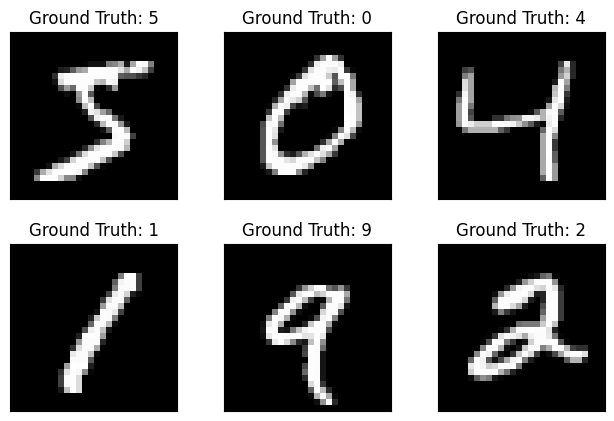

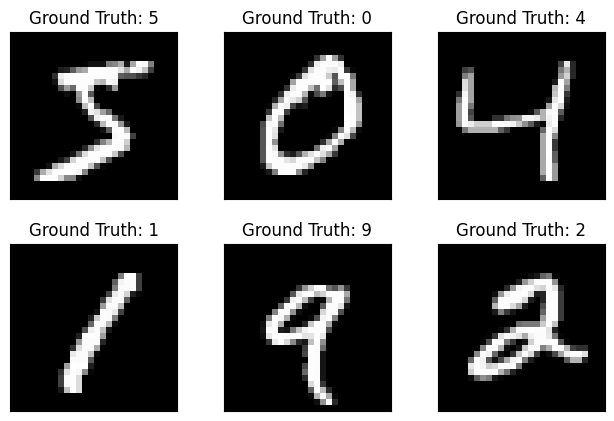

In [ ]:
train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_dataset[i][0][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(train_dataset[i][1]))
  plt.xticks([])
  plt.yticks([])
fig

#### c) The `DigitsModel` Class

In this exercise you will modify two objects: the `DigitsModel` Class and the `train` function. By default, the `DigitsModel` model includes the following layers:



In [ ]:
class DigitsModel(torch.nn.Module):
  def __init__(self, nonlinearity = 'relu', temp = 1, int_layers_depth = 0, batchnorm = False):
    super(DigitsModel, self).__init__()

    # Initialize default convolutional layers
    self.conv1_16 = torch.nn.Conv2d(1, 16, 3)
    self.conv16_32 = torch.nn.Conv2d(16, 32, 3)
    self.conv32_10 = torch.nn.Conv2d(32, 10, 3)

    # Default other modules
    self.maxpool = torch.nn.MaxPool2d(2)
    self.softmax = torch.nn.Softmax(dim = 1)

    # TODO: Add logic for the `nonlinearity` argument
    if nonlinearity == 'relu':
      self.nonlinearity = torch.nn.ReLU()
    elif nonlinearity == 'gelu':
      self.nonlinearity = torch.nn.GELU()

    # TODO: Add logic for the `temperature` argument
    self.temp = temp

    # TODO: Add logic for the `int_layers_depth` argument
    self.int_layers_depth = int_layers_depth
    if self.int_layers_depth > 0:
      self.int_layers = torch.nn.ParameterList()
      for i in range(self.int_layers_depth):
        self.int_layers.append(torch.nn.Conv2d(16, 16, 3, padding = 1))

    # TODO: Add logic for the `batchnorm` argument
    self.batchnorm = batchnorm
    if self.batchnorm:
      self.batchnorm1 = torch.nn.BatchNorm2d(16)
      self.batchnorm2 = torch.nn.BatchNorm2d(32)
    else:
      self.batchnorm1 = torch.nn.Identity()
      self.batchnorm2 = torch.nn.Identity()

    if self.int_layers_depth > 0:
      self.int_bn_layers = torch.nn.ParameterList()
      for i in range(self.int_layers_depth):
        if self.batchnorm:
          self.int_bn_layers.append(torch.nn.BatchNorm2d(16))
        else:
          self.int_bn_layers.append(torch.nn.Identity())


  def forward(self, x):
    # TODO: Add logic for `int_layers_depth`, `temp`, and `batchnorm` layers

    x = self.nonlinearity(self.batchnorm1(self.conv1_16(x)))

    # ADD ADITIONAL CONVOLUTIONAL LAYERS HERE
    if self.int_layers_depth > 0:
      for i in range(self.int_layers_depth):
        x = self.nonlinearity(self.int_bn_layers[i](self.int_layers[i](x)))

    x = self.nonlinearity(self.maxpool(self.batchnorm2(self.conv16_32(x))))

    x = self.conv32_10(x)
    x = torch.nn.functional.avg_pool2d(x, x.size()[-1])

    # TODO: Add logic for `temperature`
    return self.softmax(x.view(-1, 10) / self.temp)

How many trainable parameters does the model have? This is often a useful characteristic to know. You can find out by initializing a defaul configuration version of the model and then counting the parameters in each layer. The following code shows the number of params in a default `DigitsModel`

In [ ]:
model = DigitsModel()
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print(num_params)

7690


At $<10000$ parameters, this is an extremely lightweight model.

#### d) The `train` function:

This function initializes a model and dataloaders, then trains the model for `num_epochs` epochs on the data. It features a standard pytorch training loop.

We will return to this function frequently as we add more tunable hyperparamters. Modifying this function and the `DigitsModel` object above will produce a lightweight, extremely flexible model that can be trained in a variety of configurations.

In [ ]:
def train(num_epochs = 1, lr = 0.001, nonlinearity = 'relu', batch_size = 64,
          batchnorm = False, augmentations = None, softmax_temp = 1, add_conv_layers = 0):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Create datasets
  train_transforms = [torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,), (0.3081,)) ]

  if augmentations is not None:
    for aug in augmentations:
      if aug == 'crop':
        train_transforms.append(torchvision.transforms.RandomResizedCrop(28, scale = (0.6, 1.0)))
      elif aug == 'rotate':
        train_transforms.append(torchvision.transforms.RandomRotation(20))

  train_dataset = torchvision.datasets.MNIST('/files/', train=True, download=False,
                                              transform = torchvision.transforms.Compose(
                                                  train_transforms
                                                )) #TODO `augmentations`

  test_dataset = torchvision.datasets.MNIST('/files/', train=False, download=False,
                                              transform = torchvision.transforms.Compose([
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(
                                                    (0.1307,), (0.3081,))
                                                ]))


  # Initialize Data Loaders
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True) #TODO `batch_size`
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True) #TODO `batch_size`

  # TODO: Pass arguments to DigitsModel as you add them to the model class
  model = DigitsModel(nonlinearity = nonlinearity, temp = softmax_temp, int_layers_depth = add_conv_layers, batchnorm = batchnorm) #TODO `nonlinearity`, `temp`, `int_conv_layers`, `batchnorm`

  loss_fn = torch.nn.CrossEntropyLoss()
  model.to(device)
  loss_fn.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr) #TODO `lr`

  for epoch in range(num_epochs):

    # Training step
    model.train()
    for X, y in tqdm(train_loader):
      X = X.to(device)
      y = y.to(device)

      optimizer.zero_grad()
      preds = model(X)
      loss = loss_fn(preds, y)
      loss.backward()
      optimizer.step()

    # Evaluation step
    num_correct = 0
    model.eval()
    for X, y in test_loader:
      X = X.to(device)
      y = y.to(device)
      preds = model(X)
      num_correct += (preds.argmax(1) == y).type(torch.float).sum().item()

    print(f'Accuracy: {num_correct/len(test_dataset)}')
    # return num_correct/len(test_dataset)


We can call the `train` function now, which will initialize and train the model

In [ ]:
train()

100%|██████████| 938/938 [00:19<00:00, 48.79it/s]


0.6293

#### e) Adding Hyperparameters to the training setup

We've set up a simple training setup: a model, a dataset, and a training loop. Under defaul settings, we see relatively poor performance-- less than 70% of digits correctly recognized. To increase accuracy, we will implement **seven** model hyperparameters. Each adjusts the training behavior slightly.

As you go, you will add each hyperparameter as a parameter to the `train` function. If the hyperparameter affects the model's behavior, you will also add it as a parameter of the `DigitsModel` class. This setup will allow you to call `train(**hyperparameters)` to try a training run with a given set of hyperparameters.

To save you time and compute, we will only train the model for a single epoch at a time in these tests. In an actual setup, you would likely train for $>1$ epoch.  

##### 1. Batch Size

With larger batch sizes, models more consistently adjust their parameters in a correct direction, since there are more examples to average over. However, smaller batch sizes can mean more finely-tuned training, which will be helpful when training for only a few epochs.

Models need more memory to train with larger batches. Using larger batch sizes will make models train slightly quicker in most cases.

- **TODO:** Add `batch_size` as an argument to the `train` function, and adjust the function so a user can specify any integer batch size. Default batch size should be **64.** Train the model for a single epoch with the following batch sizes:

In [ ]:
for batch_size in [16, 64, 256]:
  print(f'Batch size: {batch_size}')
  train(batch_size = batch_size)

Batch size: 16


100%|██████████| 3750/3750 [00:24<00:00, 151.61it/s]


Accuracy: 0.6617
Batch size: 64


100%|██████████| 938/938 [00:16<00:00, 55.35it/s]


Accuracy: 0.6291
Batch size: 256


100%|██████████| 235/235 [00:16<00:00, 14.50it/s]


Accuracy: 0.4855


##### 2. Nonlinearity

Nearly all models use a nonlinear activation function. In the exercises, we've typically used a Rectified Linear Unit (`ReLU`), activation. However, several other functions can also be used. One popular function is the Gaussian Linear Unit (`GeLU`) function. Here are the two plotted side by side:

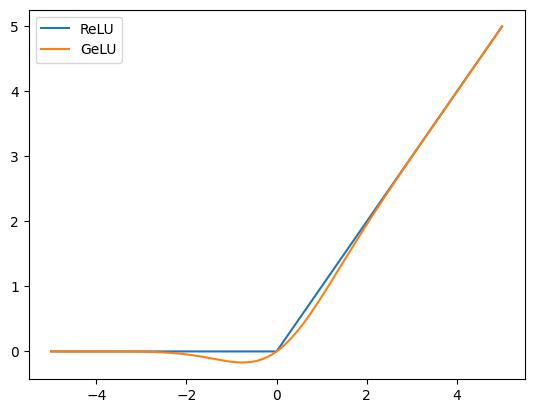

In [ ]:
x = torch.linspace(-5, 5, 1000)
relu = torch.nn.ReLU()
gelu = torch.nn.GELU()
plt.plot(x, relu(x), label = 'ReLU')
plt.plot(x, gelu(x), label = 'GeLU')
plt.legend()
plt.show()

GeLU tries to prevent "dead" neurons by preventing zero gradients in more situations.

- **TODO:** Add `nonlinearity` as an argument to the `train` function, where the options are `relu` and `gelu`. Adjust the function and the `DigitsModel` class to handle both options. The default nonlinearity should be **relu.** Train the model for a single epoch with the both nonlinearities:

In [ ]:
for nonlinearity in ['relu', 'gelu']:
  print(f'Nonlinearity: {nonlinearity}')
  train(nonlinearity = nonlinearity)

Nonlinearity: relu


100%|██████████| 938/938 [00:14<00:00, 64.06it/s]


Accuracy: 0.7468
Nonlinearity: gelu


100%|██████████| 938/938 [00:14<00:00, 64.37it/s]


Accuracy: 0.629


##### 3. Learning Rate

Learning rate is one of the most important hyperparameters. It determines how large of a step the model will adjust its weights by at each training step. Model training is often extremely sensitive to learning rate.

When adjusting the learning rate, it's standard to think in terms of powers of ten.

- **TODO:** Add `lr` as an argument to the `train` function. Adjust the function to handle any learning rate. The default learning rate should be **0.001.** Train the model for a single epoch with the the following learning rates:


In [ ]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
  print(f'Learning rate: {lr}')
  train(lr = lr)

Learning rate: 0.1


100%|██████████| 938/938 [00:16<00:00, 55.97it/s]


Accuracy: 0.0974
Learning rate: 0.01


100%|██████████| 938/938 [00:14<00:00, 64.03it/s]


Accuracy: 0.5674
Learning rate: 0.001


100%|██████████| 938/938 [00:16<00:00, 57.13it/s]


Accuracy: 0.6213
Learning rate: 0.0001


100%|██████████| 938/938 [00:14<00:00, 63.31it/s]


Accuracy: 0.3008


##### 4. Softmax Temperature

Dividing by a constant before taking the softmax of some numbers will make the output either "peakier" or "flatter". The divisor is call the "Temperature." This example shows the softmax values of a random vector with three different temperatures. Note that the distribution is flatter with `temp = 3` and peakier with `temp = 1/3`.



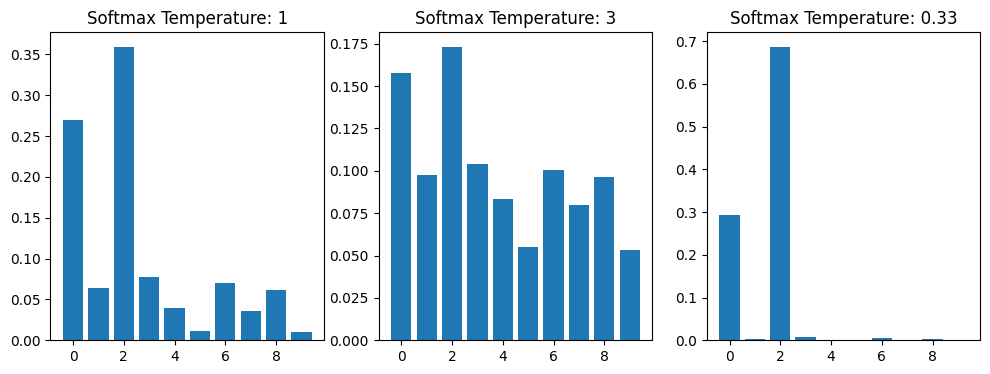

In [ ]:
ex = torch.randn(10)
temp_vals = [1, 3, 1/3]

fig, ax = plt.subplots(1, 3, figsize = (12, 4))
for i, temp in enumerate(temp_vals):
  ex_temp = ex / temp
  ax[i].bar(np.arange(10), ex_temp.softmax(0).detach().numpy())
  ax[i].set_title(f'Softmax Temperature: {round(temp, 2)}')

plt.show()

A peakier output means the model will have even higher loss when it makes incorrect predictions and even lower loss when it makes correct predictions. It will be penalized more for being wrong, which is good for training, but penalized less for being right when it not very confident about its prediction, which can be sub-optimal.

- **TODO:** Add `softmax_temp` as an argument to the `train` function. Adjust the function and the `DigitsModel` class to handle any value. The default `softmax_temp` should be **1.0.** Train the model for a single epoch with the following temperatures:

In [ ]:
for temperature in [2, 1, 0.5]:
  print(f'Softmax Temperature: {temperature}')
  train(softmax_temp = temperature)

Softmax Temperature: 2


100%|██████████| 938/938 [00:16<00:00, 57.99it/s]


Accuracy: 0.618
Softmax Temperature: 1


100%|██████████| 938/938 [00:15<00:00, 61.21it/s]


Accuracy: 0.6941
Softmax Temperature: 0.5


100%|██████████| 938/938 [00:15<00:00, 61.15it/s]


Accuracy: 0.7153


##### 5. Model Depth

Attributes of the model's architecture are also hyperparameters. For example, we might experiment by adjusting the number of convolutional filters at each step, or by adding one or more fully connected layers.

In this example, we will add additional convolutional layers **after the model's first default convolutional layer.** This spot is marked in the code. After passing through the first convolutional layer, the data has shape $(\text{Batch Size} \times 16 \times 26 \times 26)$. To add additional layers, we will add additional $3 \times 3$ convolutional layers that maintain the exact same data size. That is, the data coming out of each additional layer must also be $(\text{Batch Size} \times 16 \times 26 \times 26)$. That way, we can apply as many of these layers as we wish without affecting the remaining model steps.

Additional layers increase the model's capacity. However, they can also decrease gradients at lower layers, making initial representations less informative. In general, more layers will make a model learn faster and better. Compute time will be larger for a model with more layers.

- **TODO:** Add an `add_conv_layers` argument to the `train` function. Adjust the `train` function and the `DigitsModel` class to handle any positive integer number of additional layers. If `add_conv_layers = i`, pass the input through `i` additional convolutional layers. After each additional layer, **apply the specified nonlinearity to the output**. The default `add_conv_layers` value should be **0.**

**Tips:**

- Store the additional layers in a variably-sized `torch.nn.ParameterList`.
- Additional layers should all be 3x3 convolutions.
- Make sure that the input and output to the layers are the exact same size. That means In Channels = Out Channels. Set `padding = 1` to maintain the x and y sizes.
- If you need to verify that your model has an appropriate number of parameters, you can use the code provided in part (c).

Train the model for a single epoch with each of the following extra layers:

In [ ]:
for extra_layers in [0, 1, 2]:
  print(f'Extra Layers: {extra_layers}')
  train(add_conv_layers = extra_layers)

Extra Layers: 0


100%|██████████| 938/938 [00:24<00:00, 37.94it/s]


Accuracy: 0.5843
Extra Layers: 1


100%|██████████| 938/938 [00:16<00:00, 57.30it/s]


Accuracy: 0.6385
Extra Layers: 2


100%|██████████| 938/938 [00:16<00:00, 58.06it/s]


Accuracy: 0.5666


Note: after a single epoch, more layers will make validation accuracy higher on average, but more volitile. Don't be surprised if models with additional layers have slightly lower accuracy.

##### 6. BatchNorm

Batch Normalization addresses a key difficulty in training CNNs. In a typical training setup, the model doesn't know the distribution of values at each layer beforehand. We address this problem for the initial inputs by adding a normalization step to the initial inputs. However, a batch's intermediate outputs (after passing through one or more layers) may be strangely distributed.

BatchNorm accounts for this behavior by performing regularization on interior layers. You can learn lots more [here](https://d2l.ai/chapter_convolutional-modern/batch-norm.html).

In Pytorch, BatchNorm is typically performed using the `torch.nn.BatchNorm2d` module. This module runs on inputs of size $(\text{batch_size} \times \text{channels} \times x \times x)$ by default. The `channels` dimension is passed into the `BatchNorm2d` module as an argument.

- **TODO:** Add a `batchnorm` argument to the `train` function. Adjust the `train` function and the `DigitsModel` class to handle `True` and `False`. If `batchnorm = False`, do not apply BatchNorm to intermediate model outputs. If `batchnorm = True`, **apply BatchNorm to the output of each convolutional step except the final one**. This includes the outputs to any additional layers specified in the `add_conv_layers` argument. The default `batchnorm` value should be **False.**

**Tips:**

- Use `torch.nn.BatchNorm2d`
- If `add_conv_layers > 0`, also create a `torch.nn.ParameterList` of BatchNorm steps.
- Batchnorm Steps are already appropriately placed for the default convolutional steps. You just need to make sure `self.batchnorm1` and `self.batchnorm2` are set appropriately.
- Do not apply batchnorm to the final convolutional (32 -> 10) layer's output.

Train the model for a single epoch with and without batchnorm:

In [ ]:
for batchnorm in [True, False]:
  print(f'Batch Norm: {batchnorm}')
  train(batchnorm = batchnorm)

Batch Norm: True


100%|██████████| 938/938 [00:15<00:00, 62.00it/s]


Accuracy: 0.6992
Batch Norm: False


100%|██████████| 938/938 [00:16<00:00, 57.79it/s]


Accuracy: 0.6133


##### 7. Image Augmentations

Augmenting images can create additional "free" training data. For example, consider the following image:

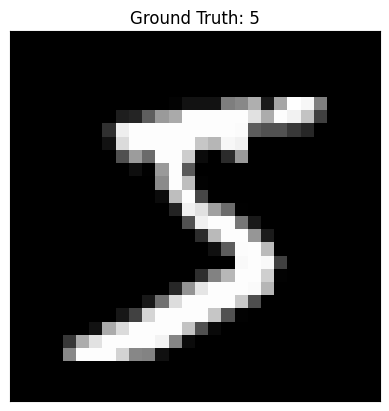

In [ ]:
ex_image, ex_label = train_dataset[0][0], train_dataset[0][1]

plt.imshow(ex_image[0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(ex_label))
plt.xticks([])
plt.yticks([])
plt.show()

For example, randomly sampling crops of sufficient size from the image produces additional views of the same data point:

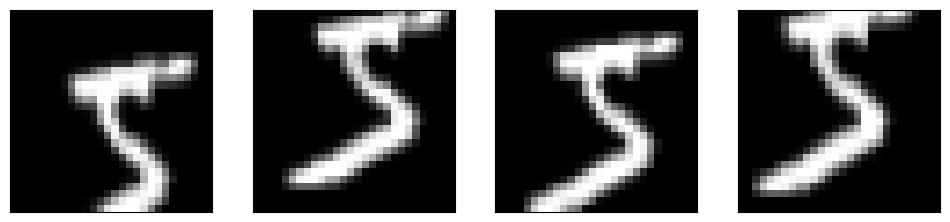

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (12, 4))
augmentation = torchvision.transforms.RandomResizedCrop(28, scale = (0.6, 0.8))

for i in range(4):
  axs[i].imshow(augmentation(ex_image)[0], cmap='gray', interpolation='none')
  axs[i].set_xticks([])
  axs[i].set_yticks([])

plt.show()

Randomly rotating the image has a similar effect:

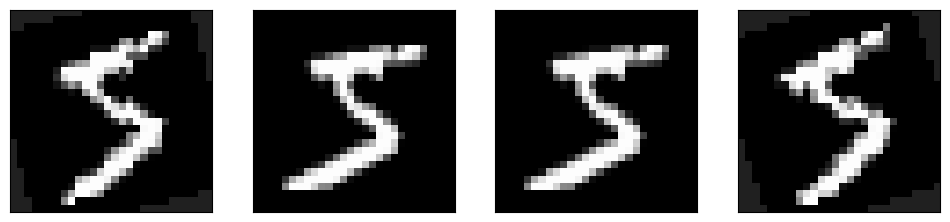

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (12, 4))
augmentation = torchvision.transforms.RandomRotation((-20, 20))

for i in range(4):
  axs[i].imshow(augmentation(ex_image)[0], cmap='gray', interpolation='none')
  axs[i].set_xticks([])
  axs[i].set_yticks([])

plt.show()

We want to be careful that inputs are still classifiable after transformation, however. Setting augmentations such that data is different from the untransformed version, but still useful to the model, can be a bit of an art. In this example, we'll apply both the transformations demoed above.

- **TODO:** Add an `augmentations` argument to the `train` function. This argument accepts a list, which contains strings `"rotate"` and `"crop"`. If the list is `[]` or `None`, apply no transformations to the images. Otherwise apply the `torch.torchvision.RandomRotation` and `torch.torchvision.RandomResizedCrop` transformations in the order specified in the list.

For example, if the list is `["rotate", "crop"]`, apply a `RandomRotation` transformation then a  `RandomResizedCrop` transformation. If the list is `["crop"]`, apply a `RandomResizedCrop` transformation.

These transformations should be applied _after_ the provided `ToTensor` and `Normalize` transformations. In `rotation` transformations, rotate the image between **-20 and 20 degrees.** In `crop` transformations, randomly crop between 60 and 100% of the image.

**Do not apply augmentations to the test images.**

Train the model for a single epoch with the following augmentations:

In [ ]:
for augmentations in [[], ['crop'], ['rotate'], ['crop', 'rotate']]:
  print(f'Augmentations: {augmentations}')
  train(augmentations = augmentations)

Augmentations: []


100%|██████████| 938/938 [00:15<00:00, 61.26it/s]


Accuracy: 0.5988
Augmentations: ['crop']


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 938/938 [00:30<00:00, 31.06it/s]


Accuracy: 0.5897
Augmentations: ['rotate']


100%|██████████| 938/938 [00:48<00:00, 19.48it/s]


Accuracy: 0.535
Augmentations: ['crop', 'rotate']


100%|██████████| 938/938 [01:03<00:00, 14.88it/s]


Accuracy: 0.4567


**Note:** These transformations are unlikely to be helpful over a single epoch for this data.
1. We are only training for a single epoch, meaning we only see each training example once. Using augmentations to "increase" training data is therefore not helpful.
2. This data is fairly standardized, so augmented views will likely simply not be as helpful to the model as standard views are.

#### f) Training with all Hyperparameters

To test the added hyperparameters, train for a single epoch with the following combination:

In [ ]:
train(lr = 0.003, nonlinearity = 'gelu', batch_size = 32, batchnorm = True, softmax_temp = 0.5, add_conv_layers = 1, augmentations = [])

100%|██████████| 1875/1875 [00:21<00:00, 88.90it/s]


0.863

#### g) Hyperparameter Tuning with Weights and Biases

To optimally train the model, we wish to find an optimal combination of hyperparameters. A website called [Weights and Biases](https://wandb.ai/site) is commonly used to optimize hyperparameters and track training runs.

In the remaining steps, we will define a hyperparameter search function, then use Weights and Biases to run and visualize our function. This section functions more as a tutorial-- provided the code above works, there is relatively little that needs to be added.

First we need to install the Weights and Biases package:


In [ ]:
!pip install wandb
import wandb

##### 1) Make a Weights and Biases account

To use Weights and Biases (WandB) you will first need to create an account (if you don't already have one). To do this go to https://wandb.ai/site and click "Sign Up."

You will need to verify you email, then provide your name, institution, and a unique username.

After that you can login to Weights and Biases from this notebook by running the following cell and pasting in your wandb API key.

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##### 2) Defining a Sweep Configuration

To run a hyperparameter search, we need to provide Weights and Biases with ranges of values to search over and a metric to optimize for. [This site](https://docs.wandb.ai/guides/sweeps/add-w-and-b-to-your-code#training-script-with-wb-python-sdk) provides a great template.

We provide these in a sweep configuration dictionary, which needs to include:

- The hyperparameter sweep method (options are grid search, random, or bayseian optimization).
- The name of the sweep
- The metric being used to evaluate the sweep
- A subdictionary named parameters, which provides a set of parameters and the values we wish to sweep over. In this case we use all seven hyperparameters implemented earlier. Reasonable search bounds are provided for each.

In [ ]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'test_sweep', # TODO: Add a sweep name here
    'metric': {'goal': 'maximize', 'name': 'val_acc'},
    'parameters':
    {
        'nonlinearity': {'values': ['relu', 'gelu']},
        'batch_size': {'values': [32, 64, 128]},
        'batchnorm': {'values': [True, False]},
        'lr': {'max': 0.01, 'min': 0.0001, 'distribution': 'log_uniform'},
        'softmax_temp': {'max': 1.0, 'min': 0.1},
        'add_conv_layers': {'values': [0, 1, 2]},
        'augmentations': {'values': [[], ['crop'], ['rotate'], ['crop', 'rotate']]}
     }
}

##### 3) **Supporting the Hyperparameter Sweep**

The weights and biases sweep process is parameterized by a callable function name, which it will run on each iteration of the sweep. Here we create a `main` function which wraps the `train` function above and trains a model for a given set of hyperparameters. This is called a "run" of the sweep. The sweep will initiate several runs and compare their performances.

`main` only needs to communicate with weights and biases to recieve a set of hyperparameters and record the trained model's performance. When a run in initizliaed, WandB supplies a dictionary at `wandb.config`which provides hyperparameters for a particular run of the hyperparameter sweep.

To track the process on Weights and Biases, `main` calls `wandb.log` after each evaluation step. This function provides data about the run to Weights and Biases. Weights and Biases uses the evaluation accuracy to inform the baysian search.

`main` is implemented below. Importantly, we need to slightly modify the `train` function to accomdate this framework.

- **TODO:** Modify the `train` function above so it:
1. Does not print any output
2. Returns the test accuracy of the trained model.

In [ ]:
def main():
  wandb.init()

  val_accuracy = train(**wandb.config)

  wandb.log({
      'epoch': 1,
      'val_acc': val_accuracy})

##### 4) **Run Hyperparameter Sweep**

Running the hyperparameter sweep has two parts:
- Register the sweep by calling `wandb.sweep`
- Call the sweep with `wandb.agent`

Those operations are provided for you, you will only need to set a project name (can be anything).

If you are not able to run the sweep on the GPU, adjust the `count` parameter from 20 to 5.

In [ ]:
# TODO: Fill in a project name
sweep_id = wandb.sweep(sweep = sweep_configuration, project= )

wandb.agent(sweep_id, function = main, count = 20)

After the sweep completes, we would typically select the highest performing iteration and use that as our final model. Generally we would train the final model for significantly longer than the sweep time.

##### 5) **Visualize Sweep Results**

You can view your hyperparameter sweep results at https://wandb.ai/{username}/{project_name}/sweeps/. There are a number of ways to view the output, including:
- Graphical Data, plotting each run against each other
- Tabular data (click the `Table` icon on the left side of the screen)

Another popular visualization technique is a [Parallel Cooridnates plot](https://docs.wandb.ai/guides/app/features/panels/parallel-coordinates), which summarizes the relationship between a large number of hyperparameters. You can create one once the sweep is done by pressing `Add panel` in the top right of the WandB dashboard, then `Parallel Coordinates`, and then selecting the relevant columns. **Make sure that val_acc is the rightmost column in the chart.** This makes sure that gradients are a signal for validation accuracy.

Here is an example of a parallel coordinates sweep for this project, with ten runs:


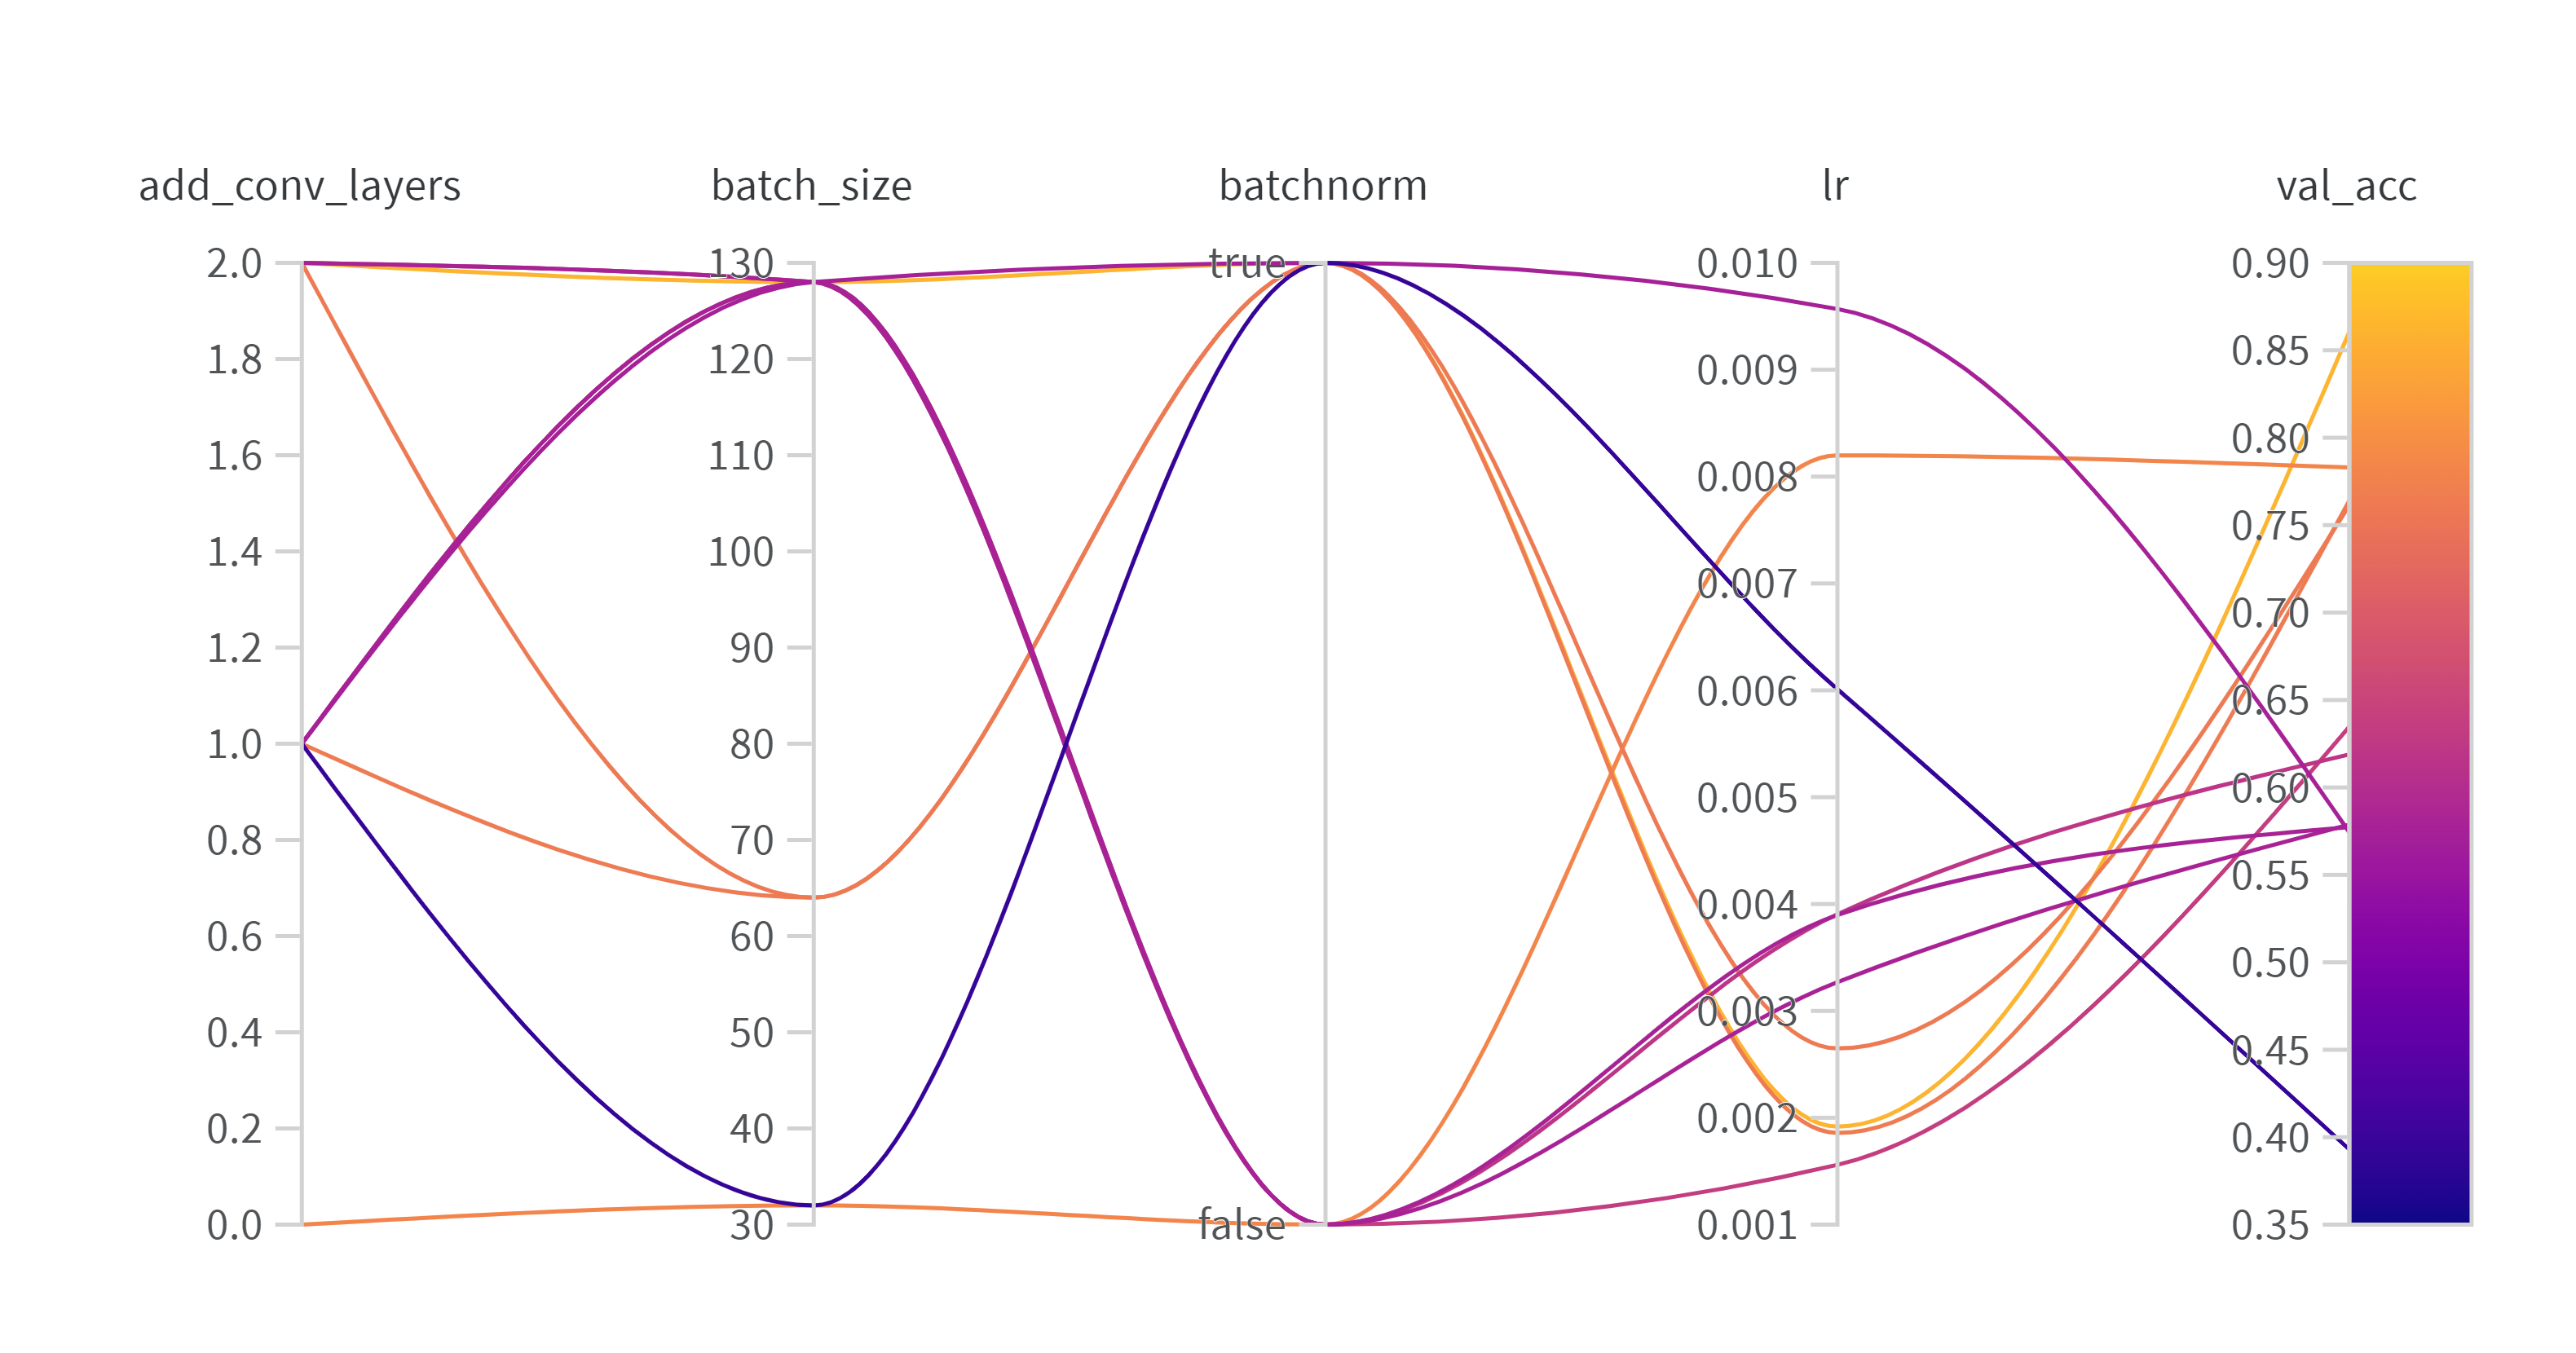

Note that the `augmentations` argument is not visualizable in this type of chart.

The gradients here seem to suggest that lower learning rate and batchnorm provides higher validation accuracy after one epoch.

**Finish this exercise by pasting in a copy of a sample parallel coordinates plot from _your_ hyperparameter sweep.**